# Präsenzversuch zum Laval-Rotor

Name:  Vincent Jestädt
Datum:  08.02.2023
Gruppe:  14

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: Sind kritische Drehzahlen der verschiedenen Rotorausführungen in dieser Versuchsauswertung ermittelbar?

## Erster Versuch: Prüfstand 3
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="images/pruefstand_3.jpeg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein: Der untersuchte Lavalrotor besteht aus einer 75 cm langen Stahlstange, an die eine 950 g schwere Stahlscheibe montiert ist. Dieser Rotor wird in Drehung versetzt und der Gleichstrommotor durchläuft verschiedene Drehzahlen. Während des Durchlaufens der verschiedenen Drehzahlen werden die Beschleunigungen des Rotors in alle Richtungen, also somit die eventuellen Schwingung aufgezeichnet. Eine Buchse in der Mitte des Rotos verhindert ein kritisches Überschwingen. 

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240117_090743_lavalrotor_14_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240117_090743_lavalrotor_14_03.h5" # name of the H5-file
print(path_measurement_folder)


measurement_data/data_20240117_090743_lavalrotor_14_03


##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240117_090743_lavalrotor_14_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240117_090743_lavalrotor_14_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240117_090743_lavalrotor_14_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240117_090743_lavalrotor_14_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
import h5py
import os



data_list = []

# Iteriere durch alle Dateien im Messordner
for filename in os.listdir(path_measurement_folder):
    if filename.endswith(".h5"):
        # Öffne die HDF5-Datei
        with h5py.File(os.path.join(path_measurement_folder, filename), "r") as hdf5_file:
            # Iteriere durch alle Schlüssel in der HDF5-Datei
            for key in hdf5_file.keys():
                try:
                    # Zugriff auf die Datensätze für sensor_acceleration_x
                    sensor_acceleration_x = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_x"][:]
                    # Zugriff auf die Datensätze für sensor_acceleration_y
                    sensor_acceleration_y = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_y"][:]
                    # Zugriff auf die Datensätze für sensor_acceleration_z
                    sensor_acceleration_z = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_z"][:]
                    # Zugriff auf die Datensätze für sensor_timestamp
                    sensor_timestamp = hdf5_file[f"{key}/RawData/{uuid_acceleration}/timestamp"][:]
                    # Zugriff auf die Datensätze für motor_rpm
                    motor_rpm = hdf5_file[f"{key}/RawData/{uuid_motor_rpm}/motor_rpm"][()]

                    data_list.append([sensor_acceleration_x, sensor_acceleration_y, sensor_acceleration_z, sensor_timestamp, motor_rpm])

                except KeyError:
                    # Handle KeyError if the required dataset is not present in the current key
                    pass



###Die Nutzung der vorgegeben Zahl und Struktur der Stützstellen erzeugte bei mir konstante Ausgabewerte nach der Interpolation.
###Dies führte nach der FFT zu vielen Nullen als Frequenz und das Diagramm war nicht lesbar.Deswegen suchte ich neue Interpolationspunkte.

#measurement_time_in_s = 10
#number_interpolation_points = 2000
#interpolation_points_1 = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)


#data_list analysieren und geeignete Interpolationspunkte finden
max_start_time = data_list[0][3][0]
min_end_time = data_list[0][3][-1]
min_mess_count = len(data_list[0][3])

# Iteriere durch alle Messungen in data_list
for i in range(len(data_list)):

    # Überprüfe, ob die Endzeit der aktuellen Messung kleiner ist als die bisherige minimale Endzeit
    if min_end_time > data_list[i][3][-1]:
        min_end_time = data_list[i][3][-1]
    # Überprüfe, ob die Startzeit der aktuellen Messung größer ist als die bisherige maximale Startzeit
    if max_start_time < data_list[i][3][0]:
        max_start_time = data_list[i][3][0]
    # Überprüfe, ob die Anzahl der Messpunkte der aktuellen Messung kleiner ist als die bisherige minimale Anzahl von Messpunkten
    if min_mess_count > len(data_list[i][3]):
        min_mess_count = len(data_list[i][3])

# Interpolationspunkte festlegen
interpolation_points = np.linspace(max_start_time, min_end_time, min_mess_count)



#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
# Interpolation der Beschleunigungsbeträge der Datensätze
data_1 = []

# Iteriere durch alle Datensätze in data_list
for data_entry in data_list:
    # Extrahiere die benötigten Daten für die Interpolation
    acceleration_data = data_entry[0]
    sensor_id = data_entry[1]
    motor_id = data_entry[2]
    timestamp_data = data_entry[3]
    rpm_data = data_entry[4]

    # Führe die Interpolation durch und füge die Ergebnisse zu data_1 hinzu
    interpolated_acceleration = m_postprocessing.interpolation(timestamp_data, m_postprocessing.get_vec_accel(acceleration_data, sensor_id, motor_id), interpolation_points)
    data_1.append([interpolated_acceleration, interpolation_points, rpm_data])

# rfft_scaled
data_2 = []

# Iteriere durch alle Datensätze in data_1
for data_entry_2 in data_1:
    # Extrahiere die benötigten Daten für die rfft und Skalierung
    interpolated_acceleration_data = data_entry_2[0]
    interpolation_points_data = data_entry_2[1]

    # Führe die rfft und Skalierung durch und füge die Ergebnisse zu data_2 hinzu
    rfft_scaled_data = m_postprocessing.my_fft_scaled(interpolated_acceleration_data, interpolation_points_data)
    data_2.append([rfft_scaled_data[0], rfft_scaled_data[1], data_entry_2[2]])


#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

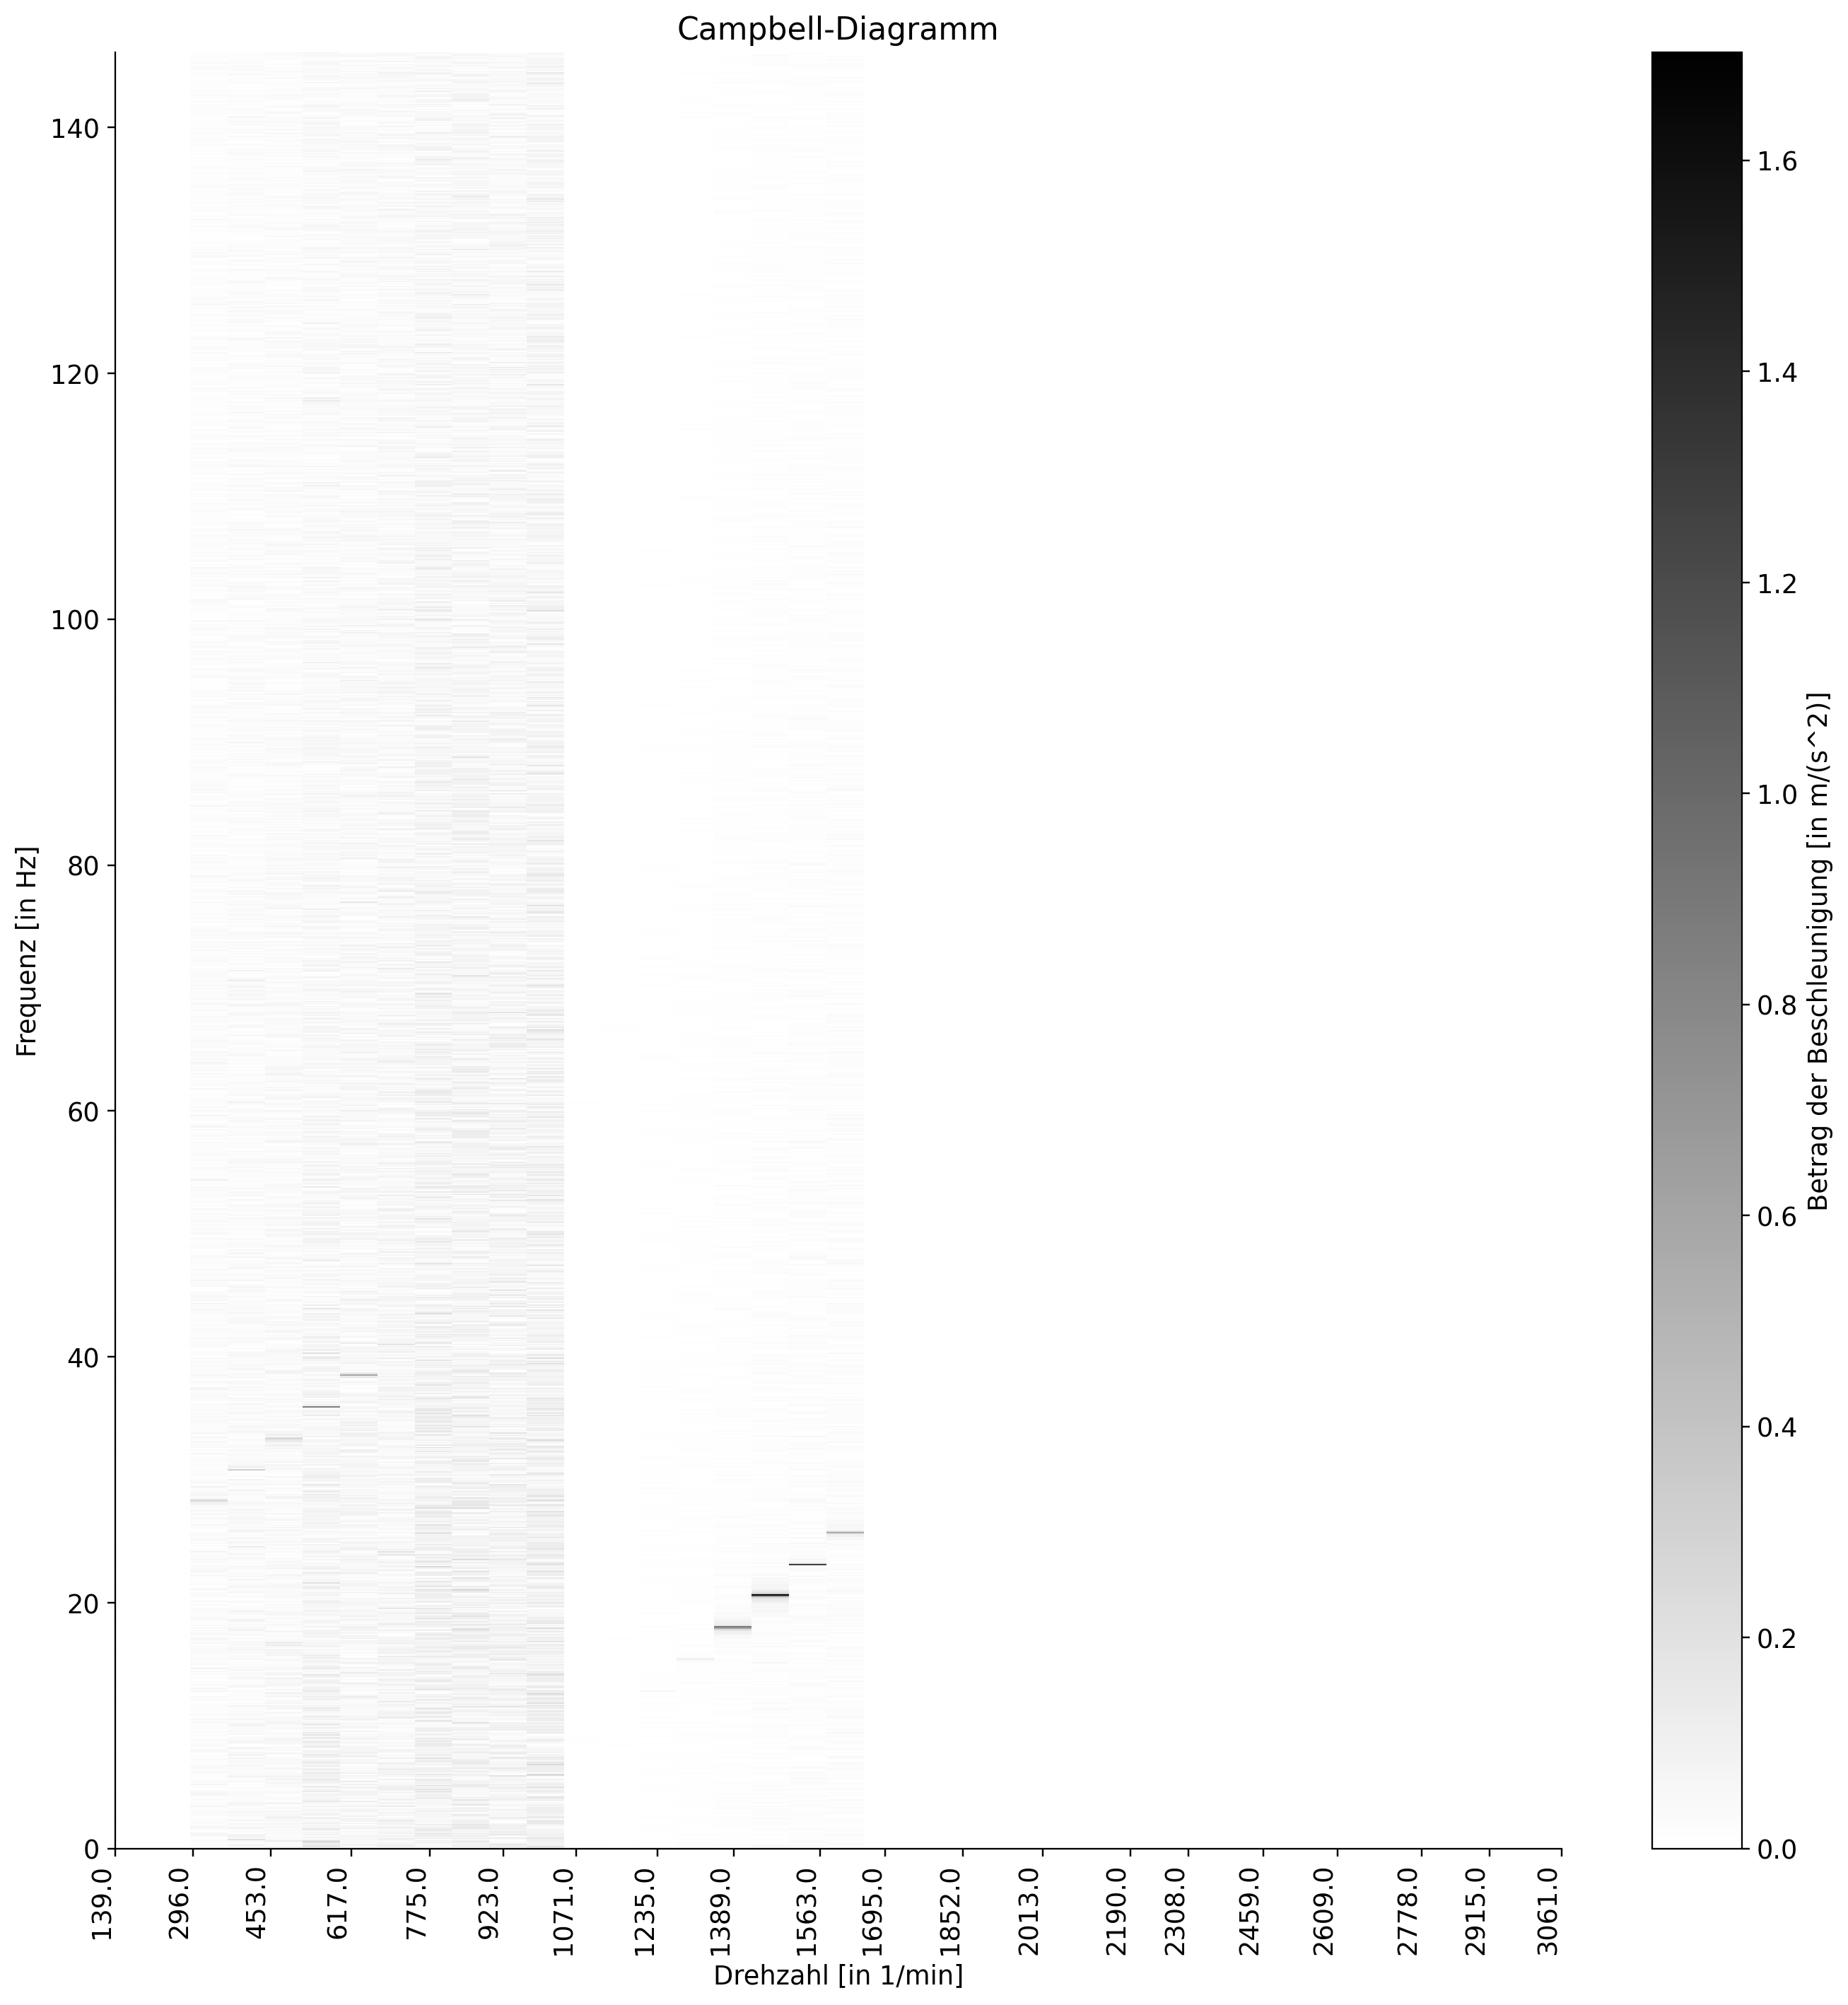

In [6]:
# Dimensionen der Matrix basierend auf Daten in data_list_3
num_frequencies = len(data_2[1][1])
num_speeds = len(data_2)
matrix = np.empty((num_frequencies, num_speeds))

# Listen für Drehzahl- und Frequenzwerte initialisieren
speeds = [float(entry[2]) for entry in data_2]
frequencies = data_2[0][1]

# Matrix mit absoluten Beschleunigungswerten füllen
for speed_index, speed_data in enumerate(data_2):
    matrix[:, speed_index] = np.abs(speed_data[0])

# Campbell-Diagramm plotten
fig, ax = plt.subplots(figsize=(15, 15))

# Extent definiert den Bereich der Achsen
extent = (min(speeds), speeds[-1] + (speeds[-1] - speeds[-2]) / 2, min(frequencies), max(frequencies))

# Plotte die Matrix als Bild mit schwarz-weißer Farbskala
plt.imshow(matrix, origin="lower", aspect="auto", interpolation="None", extent=extent, cmap="binary", vmin=matrix.min(), vmax=matrix.max())

# Setze die x-Achsen-Ticks
ax.set_xticks(speeds)
ax.set_xticklabels(speeds, rotation=90, ha='right')

# Beschrifte die Achsen und den Plot
plt.xlabel('Drehzahl [in 1/min]')
plt.ylabel('Frequenz [in Hz]')
plt.title("Campbell-Diagramm")
cbar = plt.colorbar()
cbar.set_label('Betrag der Beschleunigung [in m/(s^2)]')
plt.show()

## Zweiter Datensatz: Prüfstand 2

#### 1. Einlesen der Mess- und Metadaten

In [7]:
# Angabe der Pfade und Dateinamen
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5" # name of the H5-file
print(path_measurement_folder)

# Preparieren der Metadaten
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)


measurement_data/data_20240102_100928_lavalrotor_01_02
{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_100928_lavalrotor_01_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8

#### 2. Verarbeitung der Messdaten

In [8]:
# Initialisieren der Datenstrukturen für die Messdaten

import h5py
import os



data_list = []

# Iteriere durch alle Dateien im Messordner
for filename in os.listdir(path_measurement_folder):
    if filename.endswith(".h5"):
        # Öffne die HDF5-Datei
        with h5py.File(os.path.join(path_measurement_folder, filename), "r") as hdf5_file:
            # Iteriere durch alle Schlüssel in der HDF5-Datei
            for key in hdf5_file.keys():
                try:
                    # Zugriff auf die Datensätze für sensor_acceleration_x
                    sensor_acceleration_x = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_x"][:]
                    # Zugriff auf die Datensätze für sensor_acceleration_y
                    sensor_acceleration_y = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_y"][:]
                    # Zugriff auf die Datensätze für sensor_acceleration_z
                    sensor_acceleration_z = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_z"][:]
                    # Zugriff auf die Datensätze für sensor_timestamp
                    sensor_timestamp = hdf5_file[f"{key}/RawData/{uuid_acceleration}/timestamp"][:]
                    # Zugriff auf die Datensätze für motor_rpm
                    motor_rpm = hdf5_file[f"{key}/RawData/{uuid_motor_rpm}/motor_rpm"][()]

                    data_list.append([sensor_acceleration_x, sensor_acceleration_y, sensor_acceleration_z, sensor_timestamp, motor_rpm])

                except KeyError:
                    # Handle KeyError if the required dataset is not present in the current key
                    pass

#data_list analysieren und geeignete Interpolationspunkte finden
max_start_time = data_list[0][3][0]
min_end_time = data_list[0][3][-1]
min_mess_count = len(data_list[0][3])

# Iteriere durch alle Messungen in data_list
for i in range(len(data_list)):

    # Überprüfe, ob die Endzeit der aktuellen Messung kleiner ist als die bisherige minimale Endzeit
    if min_end_time > data_list[i][3][-1]:
        min_end_time = data_list[i][3][-1]
    # Überprüfe, ob die Startzeit der aktuellen Messung größer ist als die bisherige maximale Startzeit
    if max_start_time < data_list[i][3][0]:
        max_start_time = data_list[i][3][0]
    # Überprüfe, ob die Anzahl der Messpunkte der aktuellen Messung kleiner ist als die bisherige minimale Anzahl von Messpunkten
    if min_mess_count > len(data_list[i][3]):
        min_mess_count = len(data_list[i][3])

# Interpolationspunkte festlegen
interpolation_points = np.linspace(max_start_time, min_end_time, min_mess_count)

                
# Verarbeitung der Messdaten                

# Interpolation der Beschleunigungsbeträge der Datensätze
data_1 = []

# Iteriere durch alle Datensätze in data_list
for data_entry in data_list:
    # Extrahiere die benötigten Daten für die Interpolation
    acceleration_data = data_entry[0]
    sensor_id = data_entry[1]
    motor_id = data_entry[2]
    timestamp_data = data_entry[3]
    rpm_data = data_entry[4]

    # Führe die Interpolation durch und füge die Ergebnisse zu data_1 hinzu
    interpolated_acceleration = m_postprocessing.interpolation(timestamp_data, m_postprocessing.get_vec_accel(acceleration_data, sensor_id, motor_id), interpolation_points)
    data_1.append([interpolated_acceleration, interpolation_points, rpm_data])

# rfft_scaled
data_2 = []

# Iteriere durch alle Datensätze in data_1
for data_entry_2 in data_1:
    # Extrahiere die benötigten Daten für die rfft und Skalierung
    interpolated_acceleration_data = data_entry_2[0]
    interpolation_points_data = data_entry_2[1]

    # Führe die rfft und Skalierung durch und füge die Ergebnisse zu data_2 hinzu
    rfft_scaled_data = m_postprocessing.my_fft_scaled(interpolated_acceleration_data, interpolation_points_data)
    data_2.append([rfft_scaled_data[0], rfft_scaled_data[1], data_entry_2[2]])



#### 3. Darstellung mittels Campbell-Diagramm

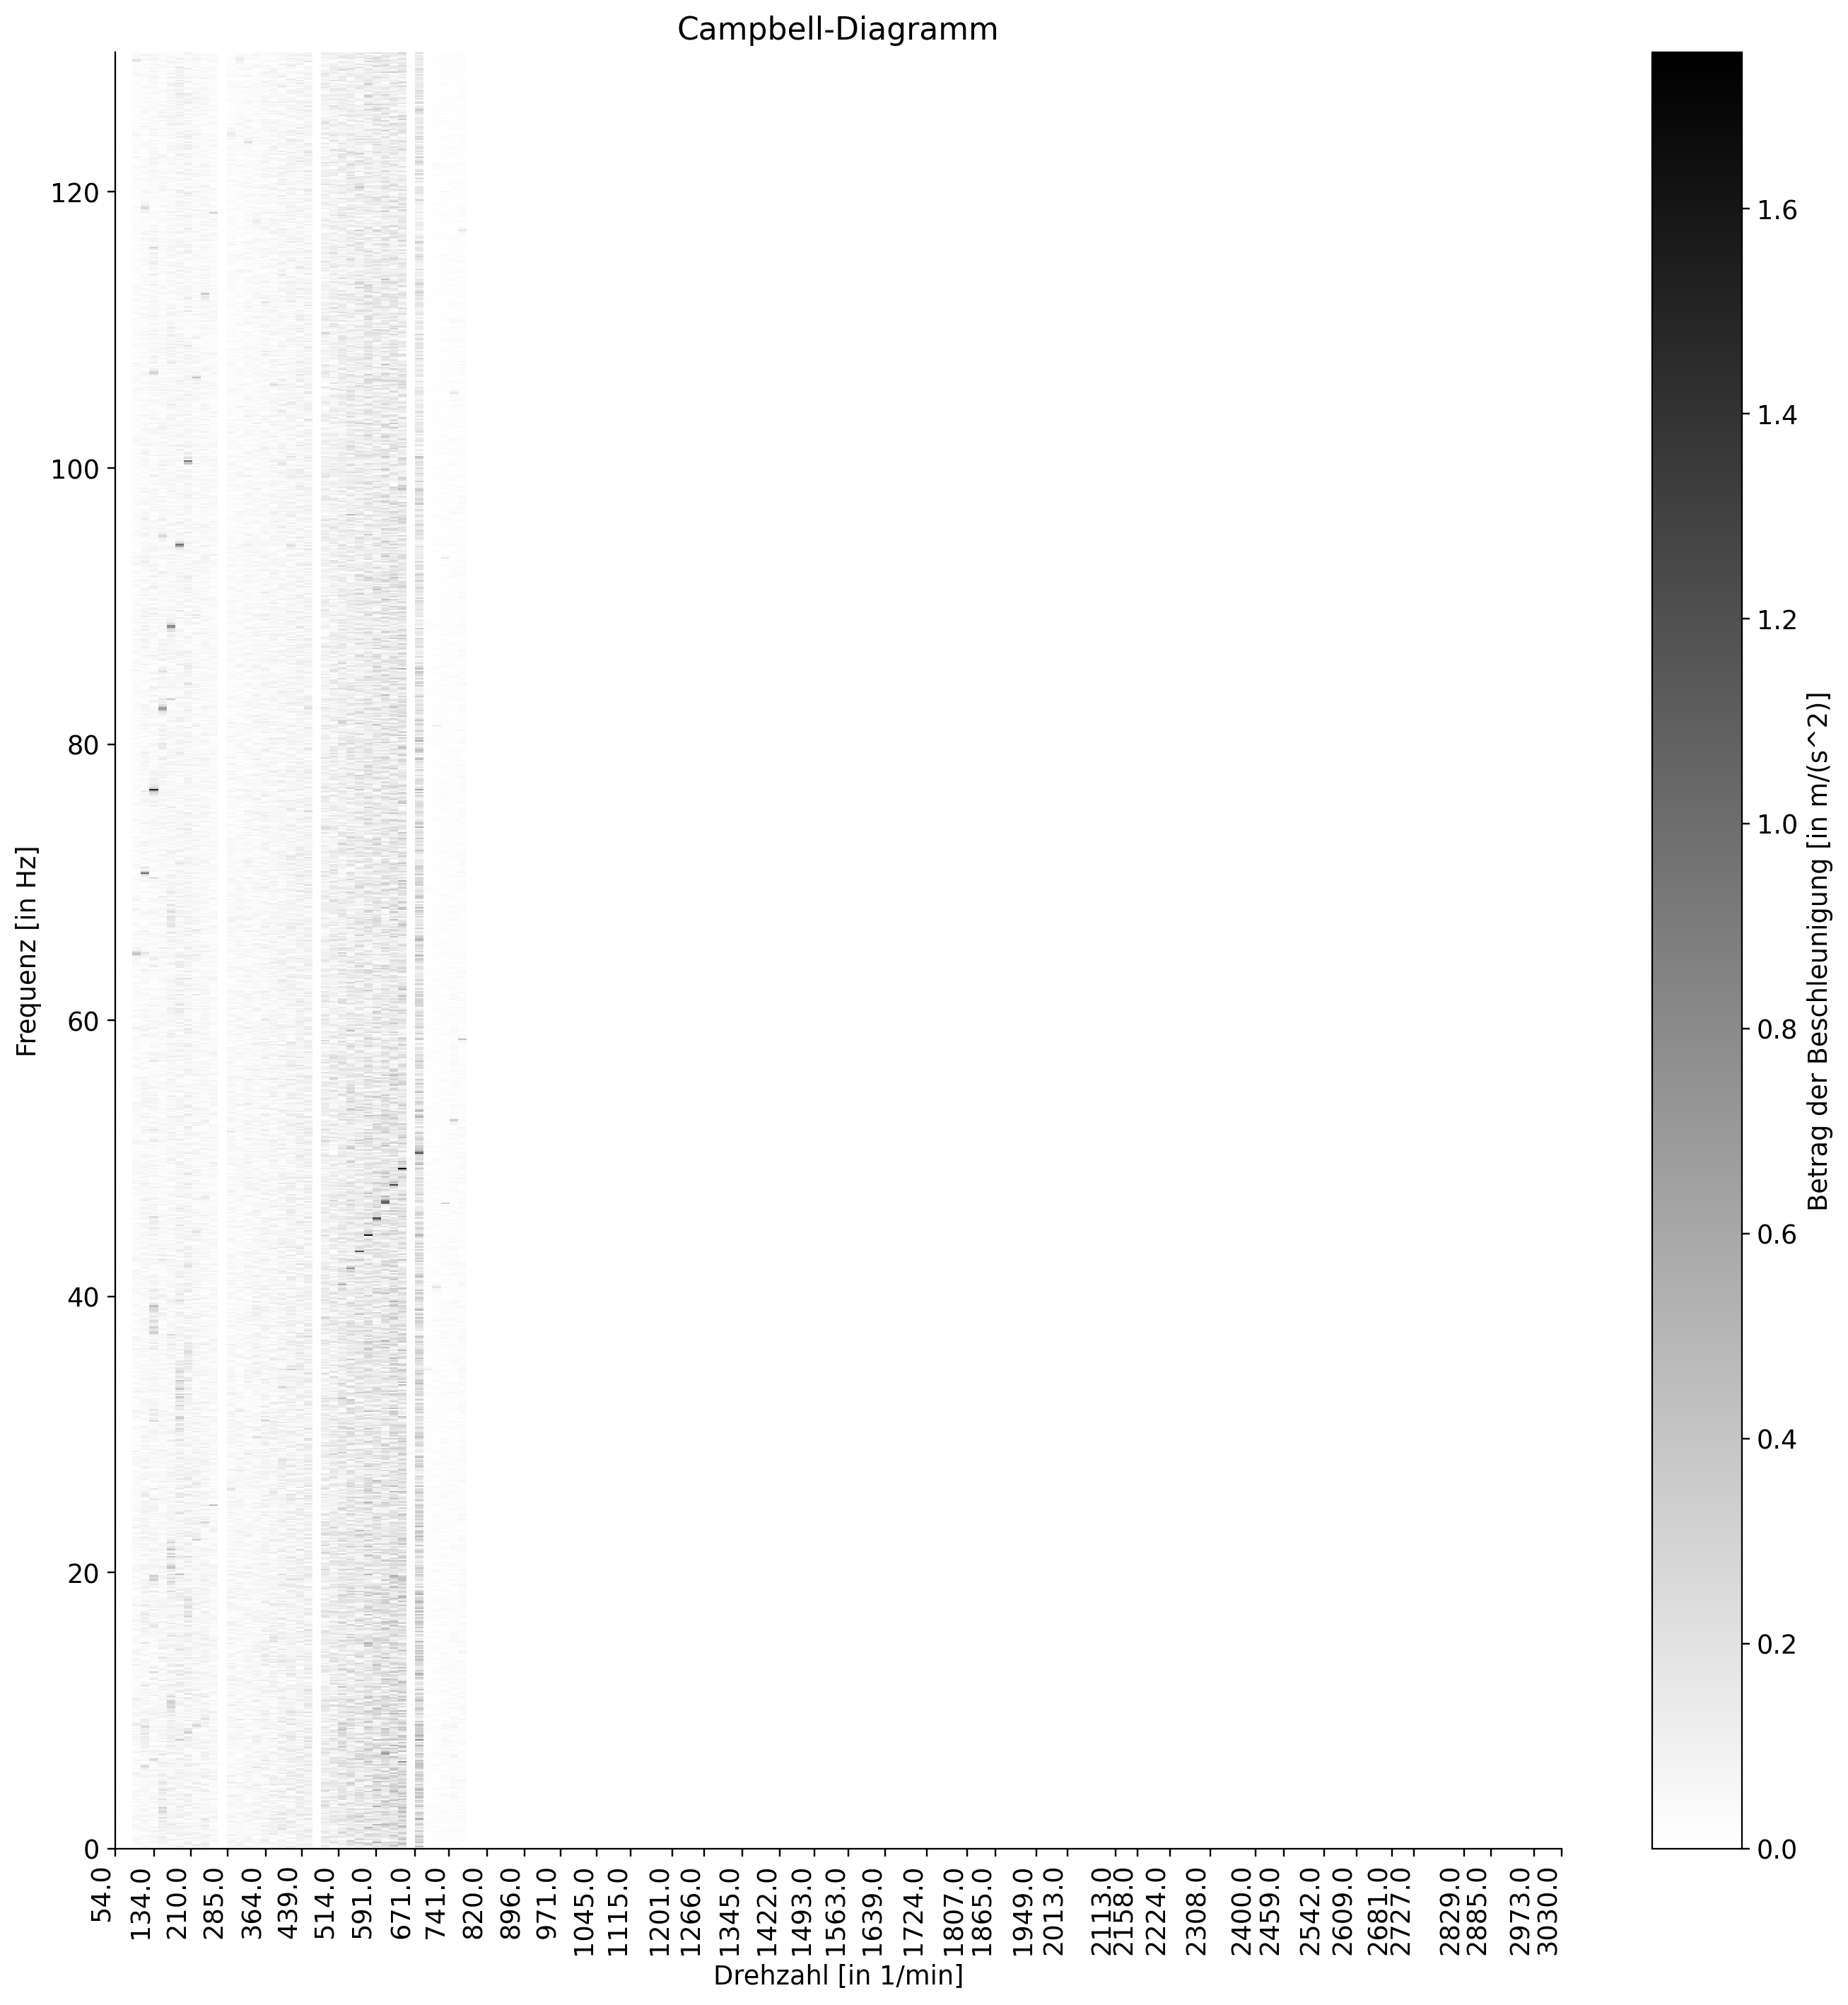

In [9]:
# Dimensionen der Matrix basierend auf Daten in data_list_3
num_frequencies = len(data_2[1][1])
num_speeds = len(data_2)
matrix = np.empty((num_frequencies, num_speeds))

# Listen für Drehzahl- und Frequenzwerte initialisieren
speeds = [float(entry[2]) for entry in data_2]
frequencies = data_2[0][1]

# Matrix mit absoluten Beschleunigungswerten füllen
for speed_index, speed_data in enumerate(data_2):
    matrix[:, speed_index] = np.abs(speed_data[0])

# Campbell-Diagramm plotten
fig, ax = plt.subplots(figsize=(15, 15))

# Extent definiert den Bereich der Achsen
extent = (min(speeds), speeds[-1] + (speeds[-1] - speeds[-2]) / 2, min(frequencies), max(frequencies))

# Plotte die Matrix als Bild mit schwarz-weißer Farbskala
plt.imshow(matrix, origin="lower", aspect="auto", interpolation="None", extent=extent, cmap="binary", vmin=matrix.min(), vmax=matrix.max())

# Setze die x-Achsen-Ticks
ax.set_xticks(speeds)
ax.set_xticklabels(speeds, rotation=90, ha='right')

# Beschrifte die Achsen und den Plot
plt.xlabel('Drehzahl [in 1/min]')
plt.ylabel('Frequenz [in Hz]')
plt.title("Campbell-Diagramm")
cbar = plt.colorbar()
cbar.set_label('Betrag der Beschleunigung [in m/(s^2)]')
plt.show()

## Dritter Datensatz: Prüfstand 4

#### 1. Einlesen der Mess- und Metadaten

In [12]:
# Angabe der Pfade und Dateinamen
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240109_104244_lavalrotor_01_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240109_104244_lavalrotor_01_04.h5" # name of the H5-file
print(path_measurement_folder)

# Preparieren der Metadaten
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)
print(uuid_acceleration, uuid_motor_rpm)


measurement_data/data_20240109_104244_lavalrotor_01_04
{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823ce-82b9-6d4e-a621-60af4e6f5cc1": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823ce-82b9-6d4e-a621-60af4e6f5cc1.json"
  },
  "1ee823b6-50dc-6670-aea5-35f6dd717e83": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee823b6-50dc-6670-aea5-35f6dd717e83.json"
  },
  "1ee8239b-46ec-63dc-8aa4-b8751ac37fd3": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240109_104244_lavalrotor_01_04/1ee8239b-46ec-63dc-8aa4-b8751ac37fd3.json"
  },
  "1ee823d6-3

#### 2. Verarbeitung der Messdaten

In [13]:
# Initialisieren der Datenstrukturen für die Messdaten

import h5py
import os



data_list = []

# Iteriere durch alle Dateien im Messordner
for filename in os.listdir(path_measurement_folder):
    if filename.endswith(".h5"):
        # Öffne die HDF5-Datei
        with h5py.File(os.path.join(path_measurement_folder, filename), "r") as hdf5_file:
            # Iteriere durch alle Schlüssel in der HDF5-Datei
            for key in hdf5_file.keys():
                try:
                    # Zugriff auf die Datensätze für sensor_acceleration_x
                    sensor_acceleration_x = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_x"][:]
                    # Zugriff auf die Datensätze für sensor_acceleration_y
                    sensor_acceleration_y = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_y"][:]
                    # Zugriff auf die Datensätze für sensor_acceleration_z
                    sensor_acceleration_z = hdf5_file[f"{key}/RawData/{uuid_acceleration}/acceleration_z"][:]
                    # Zugriff auf die Datensätze für sensor_timestamp
                    sensor_timestamp = hdf5_file[f"{key}/RawData/{uuid_acceleration}/timestamp"][:]
                    # Zugriff auf die Datensätze für motor_rpm
                    motor_rpm = hdf5_file[f"{key}/RawData/{uuid_motor_rpm}/motor_rpm"][()]

                    data_list.append([sensor_acceleration_x, sensor_acceleration_y, sensor_acceleration_z, sensor_timestamp, motor_rpm])

                except KeyError:
                    # Handle KeyError if the required dataset is not present in the current key
                    pass

#data_list analysieren und geeignete Interpolationspunkte finden
max_start_time = data_list[0][3][0]
min_end_time = data_list[0][3][-1]
min_mess_count = len(data_list[0][3])

# Iteriere durch alle Messungen in data_list
for i in range(len(data_list)):

    # Überprüfe, ob die Endzeit der aktuellen Messung kleiner ist als die bisherige minimale Endzeit
    if min_end_time > data_list[i][3][-1]:
        min_end_time = data_list[i][3][-1]
    # Überprüfe, ob die Startzeit der aktuellen Messung größer ist als die bisherige maximale Startzeit
    if max_start_time < data_list[i][3][0]:
        max_start_time = data_list[i][3][0]
    # Überprüfe, ob die Anzahl der Messpunkte der aktuellen Messung kleiner ist als die bisherige minimale Anzahl von Messpunkten
    if min_mess_count > len(data_list[i][3]):
        min_mess_count = len(data_list[i][3])

# Interpolationspunkte festlegen
interpolation_points = np.linspace(max_start_time, min_end_time, min_mess_count)

                
# Verarbeitung der Messdaten                

# Interpolation der Beschleunigungsbeträge der Datensätze
data_1 = []

# Iteriere durch alle Datensätze in data_list
for data_entry in data_list:
    # Extrahiere die benötigten Daten für die Interpolation
    acceleration_data = data_entry[0]
    sensor_id = data_entry[1]
    motor_id = data_entry[2]
    timestamp_data = data_entry[3]
    rpm_data = data_entry[4]

    # Führe die Interpolation durch und füge die Ergebnisse zu data_1 hinzu
    interpolated_acceleration = m_postprocessing.interpolation(timestamp_data, m_postprocessing.get_vec_accel(acceleration_data, sensor_id, motor_id), interpolation_points)
    data_1.append([interpolated_acceleration, interpolation_points, rpm_data])

# rfft_scaled
data_2 = []

# Iteriere durch alle Datensätze in data_1
for data_entry_2 in data_1:
    # Extrahiere die benötigten Daten für die rfft und Skalierung
    interpolated_acceleration_data = data_entry_2[0]
    interpolation_points_data = data_entry_2[1]

    # Führe die rfft und Skalierung durch und füge die Ergebnisse zu data_2 hinzu
    rfft_scaled_data = m_postprocessing.my_fft_scaled(interpolated_acceleration_data, interpolation_points_data)
    data_2.append([rfft_scaled_data[0], rfft_scaled_data[1], data_entry_2[2]])


#### 3. Darstellung mittels Campbell-Diagramm

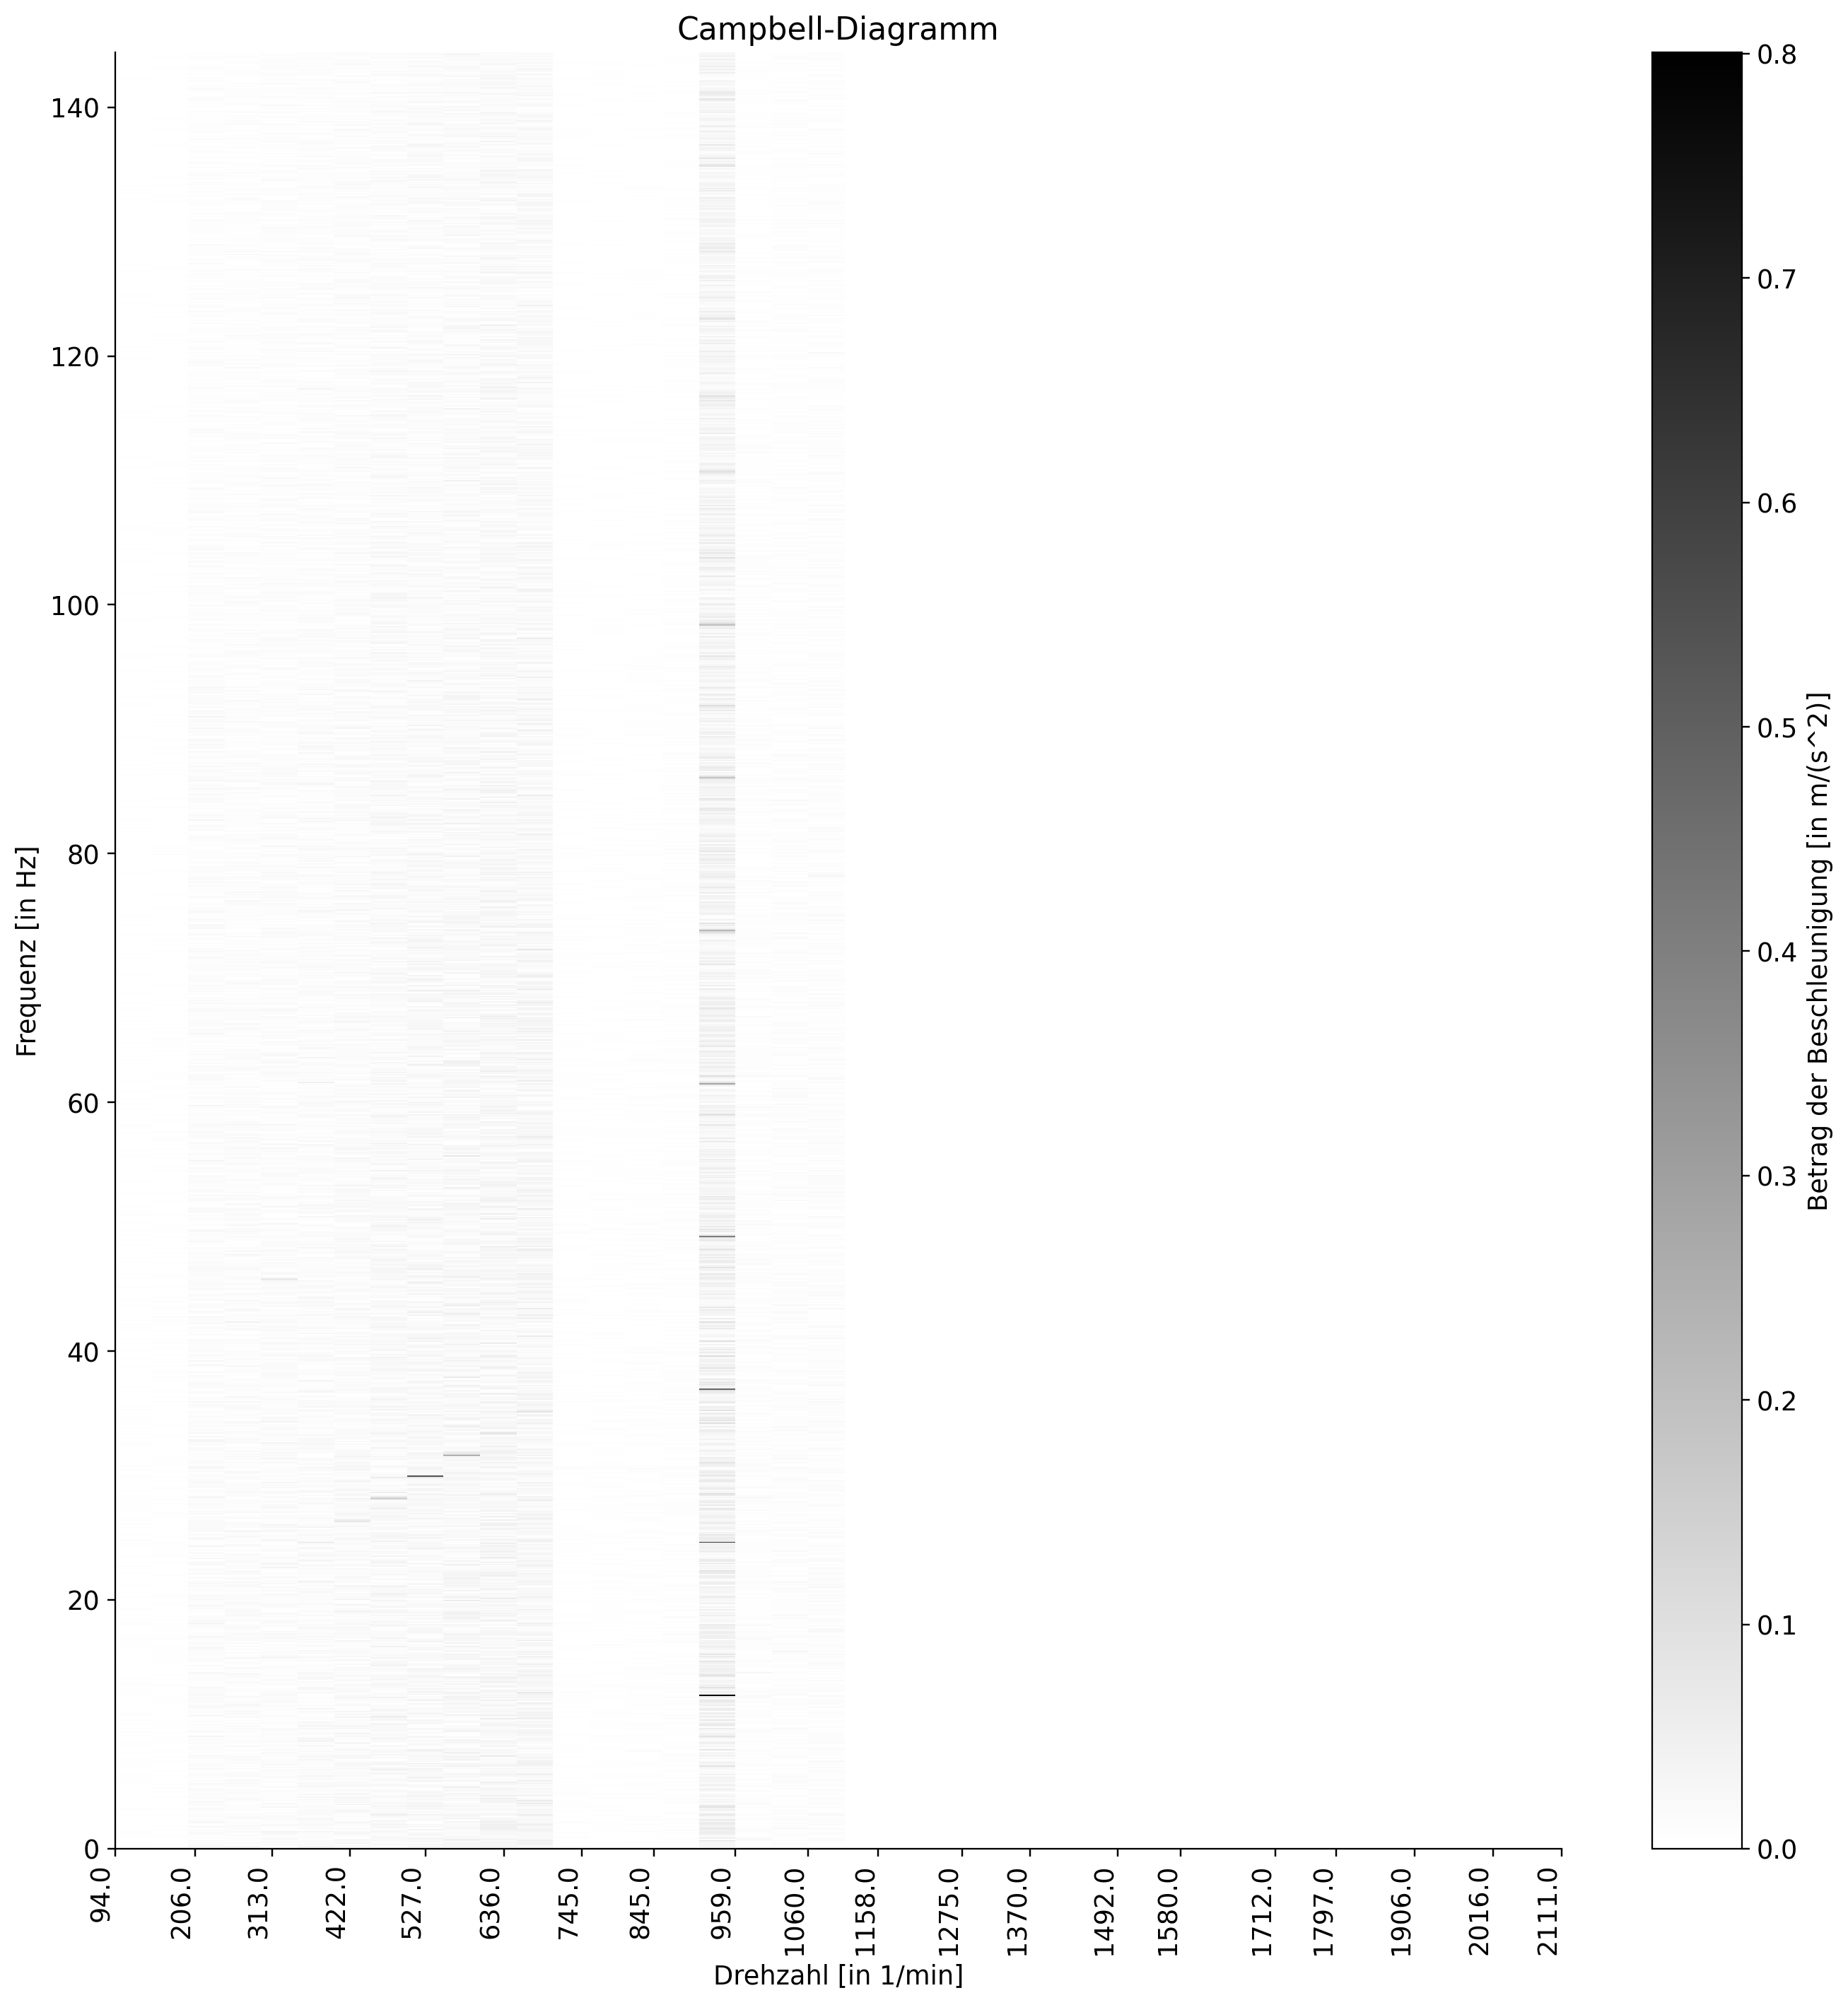

In [14]:
# Dimensionen der Matrix basierend auf Daten in data_list_3
num_frequencies = len(data_2[1][1])
num_speeds = len(data_2)
matrix = np.empty((num_frequencies, num_speeds))

# Listen für Drehzahl- und Frequenzwerte initialisieren
speeds = [float(entry[2]) for entry in data_2]
frequencies = data_2[0][1]

# Matrix mit absoluten Beschleunigungswerten füllen
for speed_index, speed_data in enumerate(data_2):
    matrix[:, speed_index] = np.abs(speed_data[0])

# Campbell-Diagramm plotten
fig, ax = plt.subplots(figsize=(15, 15))

# Extent definiert den Bereich der Achsen
extent = (min(speeds), speeds[-1] + (speeds[-1] - speeds[-2]) / 2, min(frequencies), max(frequencies))

# Plotte die Matrix als Bild mit schwarz-weißer Farbskala
plt.imshow(matrix, origin="lower", aspect="auto", interpolation="None", extent=extent, cmap="binary", vmin=matrix.min(), vmax=matrix.max())

# Setze die x-Achsen-Ticks
ax.set_xticks(speeds)
ax.set_xticklabels(speeds, rotation=90, ha='right')

# Beschrifte die Achsen und den Plot
plt.xlabel('Drehzahl [in 1/min]')
plt.ylabel('Frequenz [in Hz]')
plt.title("Campbell-Diagramm")
cbar = plt.colorbar()
cbar.set_label('Betrag der Beschleunigung [in m/(s^2)]')
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Forschungsfrage konnte mehr oder weniger beantwortet werden. Es sind bei allen drei Versuchsauswertungen kritische Frequenzen und Drehzahlen zu erkennen. Jedoch ist in Frage zu stellen inwieweit dies tatsächlich die kritischen Werte sind. Es lässt sich nur für den ersten Versuch (Versuch 3) gegenprüfen (mit den unten angeführten Rechnungen). 

Die Unterschiede zwischen den gemessenen und berechneten kritischen Drehzahlen hat vermutlich mehrere Gründe. Es können in der Berechnung der kritischen Drehzahlen unzulässige Vereinfachungen vorgenommen worden sein. Des Weiteren können Messungsicherheiten der Apparatur oder Artefakte wie Rauschen die anschließende Auswertung verändern. In all meinen Campbell-Diagrammen sind Artefakte in Form von grauen Kästchen zu sehen, was für solche Ungenauigkeiten in der Auswertung spricht. 

Bezüglich den letzten beiden Versuchen ist festzustellen, dass Versuch 2 zwei kritische Drehzahlen von 150 1/min (ca. 80 Hz) und 600 1/min besitzt. Dies stimmt mit der Überlegung überein, dass es nach dem Skriptum bei zwei Schwungscheiben auch zwei kritische Drehzahlen gibt. Der Versuch 4 zeigt eine kritische Drehzahl bei 530 1/min (30 Hz). Auch diese Anzahl der kritischen Drehzahlen stimmt mit der Anzahl an Schwungscheiben überein. Jedoch ist zu erwähnen, dass im Diagramm des vierten Versuchs ein ziemlich ausgeprägte Beschleunigung in mehreren Frequenzen bei einer Drehzahl von ca. 960 Umdrehungen zu erkennen ist. Dies kann auf eine fehlerhafte Auswertung oder eine massive Schwingung hindeuten. 

Bezüglich einer eventuellen Selbstzentrierung ist zu sagen, dass Versuch 2 und 3 zwar kritische Drehzahlen aufweisen, allerdings diese sich bei weiterer Erhöhung der Drezahl wieder reduzieren. Dies spricht für eine Selbstzentrierung. Der Versuch 4 ist aufgrund der eben beschriebenen Eigenschaft bei 960 1/min schwer auf eine Selbstzentrierung zu prüfen. 

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

Dem Skriptum entsprechend besitzt der erste Rotor nur eine kritische Frequenz, da nur eine Massenscheibe installiert wurde. Die verwendete Formel zu Berechnung der kritischen Kreisfrequenz ist: w = sqrt(k/2*m). Die Ersatzfedersteifigkeit k berechnet sich mit k = (48*E*I)/l^3 mit einem E-Modul von 210000 N/mm^2 und einem Flächenträgheitsmoment I= (r^4*pi)/4. 

Eingesetzt ergibt sich hier eine kritische Kreisfrequenz von 78 rad/s, was einer Frequenz von 12,5 Hz entspricht. Für den ersten Versuch ist eine kritische Frequenz im Campbell-Diagramm von ca. 20 Hz abzulesen (bei einer Drehzahl von ca. 1500 1/min). Diese relativ starke Abweichung lässt sich durch die oben genannten Gründe eventuell begründen.

Zu erwähnen ist hier, dass es eine weitere Schwingung bei einer Drehzahl von ca. 600 1/min und einer Frequenz von 35 Hz zu erkennen ist. Diese sollte laut den Berechnungen nicht existieren. Gründe dafür könnten Messfehler oder eine weitere größere Masse des Rotors sein, die nicht in der Berechnung berücksichtigt wurde. 

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Die Auswertung dieses Versuchs fiel mir tatsächlich ziemlich schwer. Die hier notwendige Programmierung reagierte, wie ich finde, sehr stark auf kleine Änderungen, bspw. die Interpolationspunkte. Trotzdem ist ein deutlicher Lerneffekt festzustellen. 